In [ ]:
import torch
import pandas as pd
import nltk
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchtext import data
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import numpy as np

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

torch.cuda.is_available()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# !pip install transformers

Ucitavanje podataka

In [ ]:
df = pd.read_csv("drive/MyDrive/preprocessed_sub_and_body.csv")
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)
df["length"] = df["text"].apply(len)

In [ ]:
df.head()

Unnamed: 0  label                                         text  length
0           0      0  fw: june 29 -- bna, inc. daily labor report      43
1           1      0                           ngx failover plan.      18
2           2      0                            re: intranet site      17
3           3      0         fw: ena upstream company information      36
4           4      0                          new master physical      19

In [ ]:
def plt_length():
    phishing_df = df[df["label"] == 1]
    ham_df = df[df["label"] == 0]

    _, ax = plt.subplots(figsize=(10, 4))
    sns.kdeplot(ham_df["length"], fill=True, label="Ham", color="b")
    sns.kdeplot(phishing_df["length"], fill=True, label="Phish", color="r")
    ax.set(
        xlabel="Length",
        ylabel="Density",
        title="Length of emails.",
    )
    ax.legend(loc="upper right")
    plt.show()

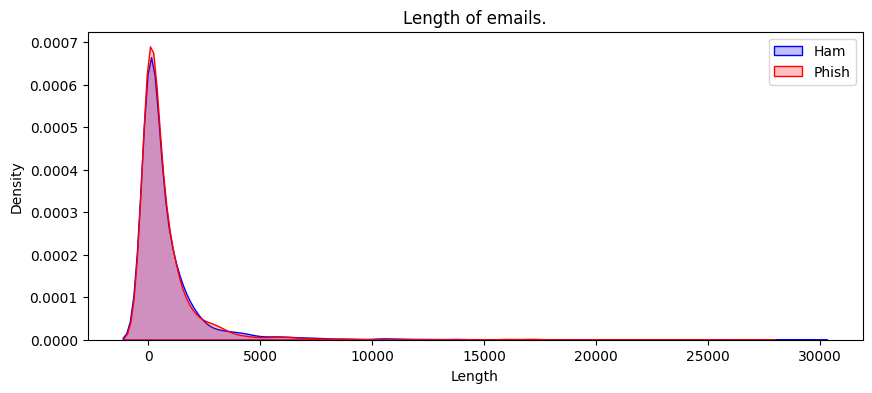

In [ ]:
plt_length()

In [ ]:
df["length"].describe()

count    11448.000000
mean       891.971960
std       2101.099586
min          1.000000
25%         35.000000
50%         93.000000
75%        937.000000
max      29191.000000
Name: length, dtype: float64

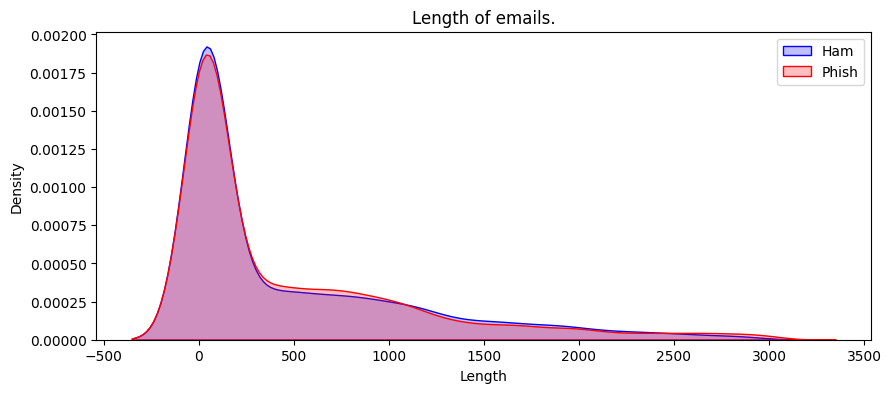

In [ ]:
df = df[df["length"] < 3000]
plt_length()

In [ ]:
df["length"].describe()

count    10706.000000
mean       472.950121
std        654.607769
min          1.000000
25%         34.000000
50%         66.000000
75%        759.000000
max       2998.000000
Name: length, dtype: float64

In [ ]:
#!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 815.8 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

Za pretprocesiranje koristimo *torchtext* biblioteku, koristeci  *spaCy* za tokenizaciju.\
Tran/Validation/Test split je u odnosu 80:10:10\
Za velicinu rjecnika uzimamo 10000, dok je minimalna frekvencija rijeci u rjecniku 5

In [ ]:
# drop unnecessary columns
df = df[["text", "label"]]

# save preprocessed data to a CSV file
df.to_csv("preprocessed_cleaned.csv", index=False)

# Field is standard column, LabelField is label column
# use spacy as tokenizer
TEXT = data.Field(
    tokenize="spacy",
    tokenizer_language="en_core_web_sm",
    lower=True,
    include_lengths=True,
    batch_first=True,
)
LABEL = data.LabelField(
    dtype=torch.float, sequential=False, use_vocab=False, batch_first=True
)

# create dataset and split into train, val and test
train_data, val_data, test_data = data.TabularDataset.splits(
    path="preprocessed_cleaned.csv",
    format="csv",
    fields=[("Text", TEXT), ("Label", LABEL)],
    split_ratio=[0.8, 0.1, 0.1],
    skip_header=True,
    random_state=random.seed(42),
)

# build vocabulary, min word frequency is 5
TEXT.build_vocab(train_data, max_size=10000, min_freq=5)

## Definisanje modela. 

Prije LSTM sloja je postavljen *Embedding* sloj u cilju izbjegavanja *sparse* vektora\
Izlaz LSTM sloja se prosleđuje na dva potpuno povezana sloja. Prvi sloj je linearni i vrši redukciju dimenzionalnosti dok drugi sadrži sigmoidnu aktivacionu funkciju čiji izlaz proizvodi opseg između 0 i 1\
*Dropout* slojevi su uključeni kako bi se sprečio overfitting nasumičnim deaktiviranjem dela neurona tokom treninga

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout1, dropout2):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(hidden_dim, 20)
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(20, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, x_lengths):
        embedded = self.embedding(x)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)  
        #output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        lstm_out = hidden[-1,:,:]
        lstm_out = self.dropout1(lstm_out)
        fc1_out = self.fc1(lstm_out)
        fc1_out = self.dropout2(fc1_out)
        fc2_out = self.fc2(fc1_out)
        output = self.sigmoid(fc2_out)
        return output


Definisemo hiperparametre za *grid search* optimizaciju

In [ ]:
# hyperparameters grid
embedding_dims = [32, 64]
hidden_dims = [100, 128]
learning_rates = [0.01, 0.001]
batch_sizes = [64, 128]
dropout_rates = [0.3, 0.4]
n_epochs = 10

best_model = None
best_val_loss = float('inf')
results = []


### Obucavanje modela

Za optimizaciju ćemo koristiti AdamW optimizer.\

Za loss funkciju je odabrana *Binary Cross Entropy*\

Koristimo *early stopping* kao bismo izbjegli *overfitting*

In [ ]:
from tqdm.auto import tqdm
import itertools
import torch.optim as optim

# BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# grid search
for embedding_dim, hidden_dim, lr, batch_size, dropout1, dropout2 in itertools.product(
        embedding_dims, hidden_dims, learning_rates, batch_sizes, dropout_rates, dropout_rates):

      # create iterators
      train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
          (train_data, val_data, test_data),
          batch_size=batch_size,
          sort_key=lambda x: len(x.body),
          sort_within_batch=True, # needed for PyTorch’s padded sequence class
          device=device
      )


      lstm_model = LSTMModel(len(TEXT.vocab), embedding_dim, hidden_dim, 1, dropout1, dropout2).to(device)
      criterion = nn.BCELoss()
      criterion = criterion.to(device)
      optimizer = optim.Adam(lstm_model.parameters(),lr=lr)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

      # early stopping criteria
      early_stopping_patience = 3
      best_epoch_val_loss = float('inf')
      epochs_no_improve = 0

      # training loop
      train_losses = []
      val_losses = []

      for epoch in range(n_epochs):

          epoch_train_loss = 0
          lstm_model.train()

          with tqdm(train_iterator, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            for batch in tepoch:
                sequences, lengths = batch.body
                labels = batch.label
                optimizer.zero_grad()
                predictions = lstm_model(sequences, lengths).squeeze()
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

          train_losses.append(epoch_train_loss / len(train_iterator))

          print(f"\nTraining epoch {epoch + 1} loss: ", epoch_train_loss)
          # TRAINING BLOCK ENDS
          print("Training complete!")


          # Validation
          lstm_model.eval()
          epoch_val_loss = 0
          val_preds = []
          val_labels = []

          with torch.no_grad():
              for batch in val_iterator:
                  sequences, lengths = batch.body
                  labels = batch.label
                  predictions = lstm_model(sequences, lengths).squeeze()
                  loss = criterion(predictions, labels)
                  epoch_val_loss += loss.item()
                  val_preds.extend(predictions.cpu().numpy())
                  val_labels.extend(labels.cpu().numpy())

          val_losses.append(epoch_val_loss / len(val_iterator))

          print(f"\nValidation epoch {epoch + 1} loss: {epoch_val_loss}")

          # early stopping
          if epoch_val_loss < best_epoch_val_loss:
              best_epoch_val_loss = epoch_val_loss
              epochs_no_improve = 0
          else:
              epochs_no_improve += 1
              if epochs_no_improve >= early_stopping_patience:
                  print(f"Early stopping triggered at epoch {epoch+1}")
                  break

          # check if current model is the best
          if val_losses[-1] < best_val_loss:
              best_val_loss = val_losses[-1]
              best_model = lstm_model

          # record the results for this hyperparameter configuration
          results.append({
              'embedding_dim': embedding_dim,
              'hidden_dim': hidden_dim,
              'lr': lr,
              'batch_size': batch_size,
              'dropout1': dropout1,
              'dropout2': dropout2,
              'n_epochs': n_epochs,
              'train_loss': train_losses[-1],
              'val_loss': val_losses[-1]
          })

best_hyperparams = min(results, key=lambda x: x['val_loss'])
print("Best Hyperparameters:")
print(best_hyperparams)


Čuvanje modela i optimizera

In [ ]:
model_save_path = 'drive/MyDrive/lstm_torch_model.pt'
optimizer_save_path = 'drive/MyDrive/lstm_torch_optimizer.pt'

torch.save(best_model.state_dict(), model_save_path)

torch.save(optimizer.state_dict(), optimizer_save_path)

print("Model and optimizer state saved successfully.")

Model and optimizer state saved successfully.


## Rezime i vizualizacija rezultata obučavanja 

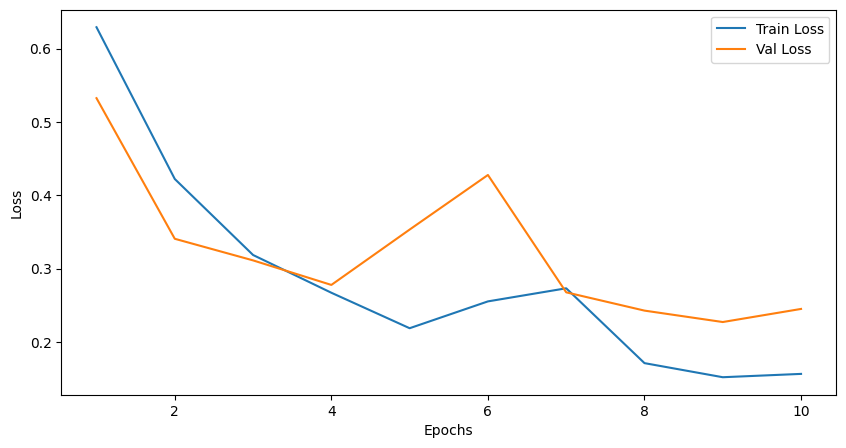

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, best_hyperparams["n_epochs"] + 1), train_losses, label="Train Loss")
plt.plot(range(1, best_hyperparams["n_epochs"] + 1), val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Primjecujemo da iako *Training loss* opada *Validation loss* raste nakon seste i desete epohe, sto nam sugeriše da nam model potencijalno overfituje

### Evaluacija nad testnim podacima

In [ ]:
# evaluation on test set
lstm_model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_iterator:
        sequences, lengths = batch.body
        labels = batch.label
        predictions = lstm_model(sequences, lengths).squeeze()
        test_preds.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


# convert to binary predictions
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# calculate metrics
accuracy = accuracy_score(test_labels, test_preds_binary)
precision = precision_score(test_labels, test_preds_binary)
recall = recall_score(test_labels, test_preds_binary)
f1 = f1_score(test_labels, test_preds_binary)
roc_auc = roc_auc_score(test_labels, test_preds)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")
print(f"Test F1 Score: {f1*100:.2f}%")
print(f"Test ROC AUC: {roc_auc*100:.2f}%")

Test Accuracy: 91.69%
Test Precision: 90.83%
Test Recall: 93.86%
Test F1 Score: 92.32%
Test ROC AUC: 97.30%
